# Day 1: MADlib을 활용한 전복(abalone) 성숙 여부(mature) 분류

MADlib의 **(1) Logistic Regression, (2) Random Forest Classifier** 를 이용하여  
**전복의 성숙(mature), 미성숙(immature) 여부를 판별하는 이진 분류(binary classification)** 하는 문제입니다.  
나이(age) = rings + 1.5 이며, 나이가 10살 이상이면 성숙(mature)으로 정의합니다. 

## 데이터셋(abalone.data) 소개

예제로 사용할 데이터셋은 __[UC Irvine Machine Learning Repository](http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data)__에 공개되어 있는 abalone.data.txt 파일입니다. 

### Attribute Information: 
----
** Name / Data Type / Measurement Unit / Description  **

Sex / nominal / -- / M, F, and I (infant)  
Length / continuous / mm / Longest shell measurement  
Diameter	/ continuous / mm / perpendicular to length  
Height / continuous / mm / with meat in shell  
Whole weight / continuous / grams / whole abalone  
Shucked weight / continuous	/ grams / weight of meat  
Viscera weight / continuous / grams / gut weight (after bleeding)  
Shell weight / continuous / grams / after being dried  
**Rings / integer / -- / +1.5 gives the age in years  **

---- 

## Notebook 환경 설정

In [1]:
import numpy as np
import pandas as pd
import math
import six
from sqlalchemy import create_engine # DB 연동

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# notebook 안에서 그래프 보기
%matplotlib inline

pd.set_option('display.max_columns', 200)

의사결정나무 시각화를 위해 Graphviz 오픈소스 설치가 필요합니다. Graphviz 설치에 문제가 있을 경우 https://www.graphviz.org/download/ 를 참고하세요. 

In [3]:
# !pip install graphviz
import graphviz

## GPDB 연결

- **dbconnect.py**는 GPDB에 연결하고, Jupyter Notebook에서 SQL을 사용할 수 있도록 해주는 __[SQL Magic](http://engineering.pivotal.io/post/introducing-sql-magic/)__을 쉽게 설정할 수 있도록 도와주는 custom module입니다. dbconnect.py 파일을 Jupyter Notebook이 실행되는 폴더에 넣고 아래의 import dbconnect를 실행시켜 주세요. </br>


- 아래처럼 GPDB의 host, port, user, database, password 정보가 입력된 **db_credentials.txt** 파일을 dbconnect.py 파일과 같은 폴더에 넣어주세요. 

> [database_creds]  
host: localhost  
port: 5432  
user: gpadmin  
database: gpadmin  
password: pivotal  

In [4]:
import dbconnect

In [5]:
db_credential_file = 'db_credentials.txt'
dbconnect.connect_and_register_sql_magic(
    db_credential_file, 
    conn_name='conn'
)

Connection object assigned to `conn`


## Abalone 데이터셋을 GPDB에 업로드 하기

- 한줄짜리 SQL이면 **%%read_sql**을 쓰고, 같은 줄에 SQL문을 써줍니다. 
- 두줄 이상의 SQL이면 **%%read_sql**을 먼저 써주고, 그 다음줄부터 SQL을 써주면 됩니다. 

In [6]:
schema = 'ds_training'

In [7]:
%read_sql DROP SCHEMA IF EXISTS {schema} CASCADE;
%read_sql CREATE SCHEMA {schema};

Query started at 10:04:05 PM KST; Query executed in 0.00 m

- Web에 있는 abalone 데이터셋을 External Table로 먼저 가져옵니다. 

In [8]:
%%read_sql
-- External Table
DROP EXTERNAL TABLE IF EXISTS {schema}.abalone_external;
CREATE EXTERNAL WEB TABLE {schema}.abalone_external(
    sex text 
    , length float8
    , diameter float8
    , height float8
    , whole_weight float8
    , shucked_weight float8
    , viscera_weight float8
    , shell_weight float8
    , rings integer -- target variable to predict
) location('http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data') 
format 'CSV' 
(null as '?');

Query started at 10:04:06 PM KST; Query executed in 0.00 m

- External Table에서 데이터를 가져다가 GPDB에 abalone table을 생성합니다. 

In [9]:
%%read_sql
-- Create a table at Greenplum Database from external table
DROP TABLE IF EXISTS {schema}.abalone;
CREATE TABLE {schema}.abalone AS
    SELECT row_number() over() AS id, * 
    FROM {schema}.abalone_external
    DISTRIBUTED BY (sex);

Query started at 10:04:07 PM KST; Query executed in 0.02 m

In [10]:
%read_sql SELECT * FROM {schema}.abalone LIMIT 5;

Query started at 10:04:08 PM KST; Query executed in 0.00 m

,id,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,3,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.21,9
1,7,F,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.33,20
2,8,F,0.545,0.425,0.125,0.7680,0.2940,0.1495,0.26,16
3,10,F,0.550,0.440,0.150,0.8945,0.3145,0.1510,0.32,19
4,11,F,0.525,0.380,0.140,0.6065,0.1940,0.1475,0.21,14


## Target 변수 탐색 및 정의
- %%read_sql 다음에 -d 는 조회결과를 화면에 나타내지 말라는 것이며, 아래 예처럼 'df_abalone'를 써주면 pandas DataFrame을 만들어줍니다. 
- age = rings + 1.5

In [11]:
%%read_sql -d df_abalone
SELECT * FROM {schema}.abalone

Query started at 10:04:08 PM KST; Query executed in 0.00 m

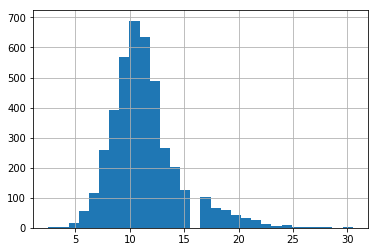

In [12]:
(df_abalone.rings + 1.5).hist(bins=30)

In [13]:
((df_abalone.rings + 1.5) >= 10).value_counts()

True     2770
False    1407
Name: rings, dtype: int64

In [14]:
_cumsum = (df_abalone.rings + 1.5).value_counts().sort_index().cumsum()
_cumsum / df_abalone.shape[0]

2.5     0.000239
3.5     0.000479
4.5     0.004070
5.5     0.017716
6.5     0.045248
7.5     0.107254
8.5     0.200862
9.5     0.336845
10.5    0.501796
11.5    0.653579
12.5    0.770170
13.5    0.834091
14.5    0.882691
15.5    0.912856
16.5    0.937515
17.5    0.953555
18.5    0.967441
19.5    0.977496
20.5    0.985157
21.5    0.991381
22.5    0.994733
23.5    0.996169
24.5    0.998324
25.5    0.998803
26.5    0.999042
27.5    0.999282
28.5    0.999761
30.5    1.000000
Name: rings, dtype: float64

- age = rings + 1.5
- target 변수 정의: 연령 10년 이상이면 성숙(mature), 10년 미만이면 미성숙(immature)
- 성별 코드(M, F, I)를 대문자에서 소문자로 변환

In [15]:
%%read_sql
DROP TABLE IF EXISTS {schema}.abalone_target;
CREATE TABLE {schema}.abalone_target AS 
    SELECT 
        id
        , lower(sex) as sex
        , length
        , diameter
        , height
        , whole_weight
        , shucked_weight
        , viscera_weight
        , shell_weight
        , rings
        , rings + 1.5 AS age
        , CASE WHEN (rings + 1.5) >= 10 THEN 1 ELSE 0 END AS mature
    FROM {schema}.abalone

Query started at 10:04:09 PM KST; Query executed in 0.00 m

In [16]:
%read_sql SELECT * FROM {schema}.abalone_target ORDER BY id LIMIT 5;

Query started at 10:04:09 PM KST; Query executed in 0.00 m

,id,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,age,mature
0,1,m,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,16.5,1
1,2,m,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,8.5,0
2,3,f,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,10.5,1
3,4,m,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,11.5,1
4,5,i,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,8.5,0


In [17]:
%%read_sql 
SELECT count(*) AS total_cnt, sum(mature) AS mature_cnt, 100*sum(mature)/count(*) AS mature_ratio
FROM {schema}.abalone_target;

Query started at 10:04:10 PM KST; Query executed in 0.00 m

,total_cnt,mature_cnt,mature_ratio
0,4177,2770,66


## 탐색적 데이터 분석

- 요약 통계량: 빈도, 결측값, 평균, 분산, 95% 신뢰구간, 최소값, 최대값, 4분위수, 중앙값, 최빈값
- MADlib Summary Function: http://madlib.apache.org/docs/latest/group__grp__summary.html

In [18]:
%%read_sql -d
DROP TABLE IF EXISTS {schema}.abalone_summary CASCADE;
SELECT madlib.summary(
    '{schema}.abalone_target'    -- source table
    , '{schema}.abalone_summary' -- output table
    , 'sex, length, diameter, height, whole_weight, shucked_weight, viscera_weight, shell_weight, mature' -- target column
    , NULL                       -- grouping column
)

Query started at 10:04:11 PM KST; Query executed in 0.01 m

In [19]:
%read_sql SELECT * FROM {schema}.abalone_summary;

Query started at 10:04:11 PM KST; Query executed in 0.00 m

,group_by,group_by_value,target_column,column_number,data_type,row_count,distinct_values,missing_values,blank_values,fraction_missing,fraction_blank,positive_values,negative_values,zero_values,mean,variance,confidence_interval,min,max,first_quartile,median,third_quartile,most_frequent_values,mfv_frequencies
0,None,None,sex,2,text,4177,3,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,None,1.0000,1.0000,NaN,NaN,NaN,"[m, m, i, i, f, f]","[1528, 1528, 1342, 1342, 1307, 1307]"
1,None,None,length,3,float8,4177,134,0,NaN,0.0,NaN,4177.0,0.0,0.0,0.523992,0.014422,"[0.520350088942873, 0.527634110243144]",0.0750,0.8150,0.4500,0.5450,0.615,"[0.55, 0.625, 0.625, 0.55, 0.575, 0.575, 0.58,...","[94, 94, 94, 94, 93, 93, 92, 92, 87, 87]"
2,None,None,diameter,4,float8,4177,111,0,NaN,0.0,NaN,4177.0,0.0,0.0,0.407881,0.009849,"[0.404871645997761, 0.410890862979975]",0.0550,0.6500,0.3500,0.4250,0.480,"[0.45, 0.45, 0.475, 0.475, 0.4, 0.4, 0.5, 0.5,...","[139, 139, 120, 120, 111, 111, 110, 110, 100, ..."
3,None,None,height,5,float8,4177,51,0,NaN,0.0,NaN,4175.0,0.0,2.0,0.139516,0.001750,"[0.138247926591563, 0.140784872067762]",0.0000,1.1300,0.1150,0.1400,0.165,"[0.15, 0.15, 0.14, 0.14, 0.155, 0.155, 0.175, ...","[267, 267, 220, 220, 217, 217, 211, 211, 205, ..."
4,None,None,whole_weight,6,float8,4177,2429,0,NaN,0.0,NaN,4177.0,0.0,0.0,0.828742,0.240481,"[0.813870324055099, 0.843613994834056]",0.0020,2.8255,0.4415,0.7995,1.153,"[0.196, 0.2225, 1.114, 0.494, 0.97, 0.44, 0.32...","[8, 8, 7, 7, 7, 7, 6, 6, 6, 5]"
5,None,None,shucked_weight,7,float8,4177,1515,0,NaN,0.0,NaN,4177.0,0.0,0.0,0.359367,0.049268,"[0.352636105342963, 0.366098871913443]",0.0010,1.4880,0.1860,0.3360,0.502,"[0.175, 0.2505, 0.419, 0.165, 0.302, 0.1255, 0...","[11, 10, 9, 9, 9, 8, 8, 8, 8, 7]"
6,None,None,viscera_weight,8,float8,4177,880,0,NaN,0.0,NaN,4177.0,0.0,0.0,0.180594,0.012015,"[0.177269379483621, 0.183917836221431]",0.0005,0.7600,0.0935,0.1710,0.253,"[0.1715, 0.196, 0.037, 0.1735, 0.1405, 0.1905,...","[15, 14, 13, 12, 12, 12, 12, 12, 12, 11]"
7,None,None,shell_weight,9,float8,4177,926,0,NaN,0.0,NaN,4177.0,0.0,0.0,0.238831,0.019377,"[0.234609314715373, 0.243052404221663]",0.0015,1.0050,0.1300,0.2340,0.329,"[0.275, 0.275, 0.25, 0.25, 0.315, 0.185, 0.265...","[43, 43, 42, 42, 40, 40, 40, 40, 37, 37]"
8,None,None,mature,12,int4,4177,2,0,NaN,0.0,NaN,2770.0,0.0,1407.0,0.663155,0.223434,"[0.648820355293342, 0.67749039404829]",0.0000,1.0000,0.0000,1.0000,1.000,"[1, 1, 0, 0]","[2770, 2770, 1407, 1407]"


> 결측값(missing value) 없음  
> 높이(height) '0'인 관측치 확인 필요

- abalone 데이터셋을 로컬 클라이언트 컴퓨터에서는 처리할 수 없는 매우 큰 크기의 데이터셋이라고 가정합시다. 
- 연속형 변수를 성별(sex) 기준 stratified random sampling하여 Python으로 히스토그램(histogram), 산점도 행렬(scatter plot matrix) 그려보겠습니다. 
- MADlib Stratified Random Sampling: http://madlib.apache.org/docs/latest/group__grp__strs.html

In [20]:
%%read_sql -d
DROP TABLE IF EXISTS {schema}.abalone_sample;
SELECT madlib.stratified_sample(
    '{schema}.abalone_target'   -- source table
    , '{schema}.abalone_sample' -- output table
    , 0.9                       -- sample proportion
    , 'sex'                     -- strata definition
    , 'length, diameter, height, whole_weight, shucked_weight, viscera_weight, shell_weight, mature' -- columns to output
    , FALSE                     -- FALSE means 'sampling without replacement'
)

Query started at 10:04:12 PM KST; Query executed in 0.00 m

In [21]:
%%read_sql -d df_abalone_sample
SELECT * FROM {schema}.abalone_sample;

Query started at 10:04:12 PM KST; Query executed in 0.00 m

In [22]:
%%read_sql
SELECT sex, count(*) FROM {schema}.abalone_sample GROUP BY sex;

Query started at 10:04:13 PM KST; Query executed in 0.00 m

,sex,count
0,i,1208
1,m,1376
2,f,1177


- Python seaborn 라이브러리를 이용한 산점도 행렬(scatter plot matrix) 시각화

/Users/ihongdon/anaconda3/envs/py3.5_tf1.4/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


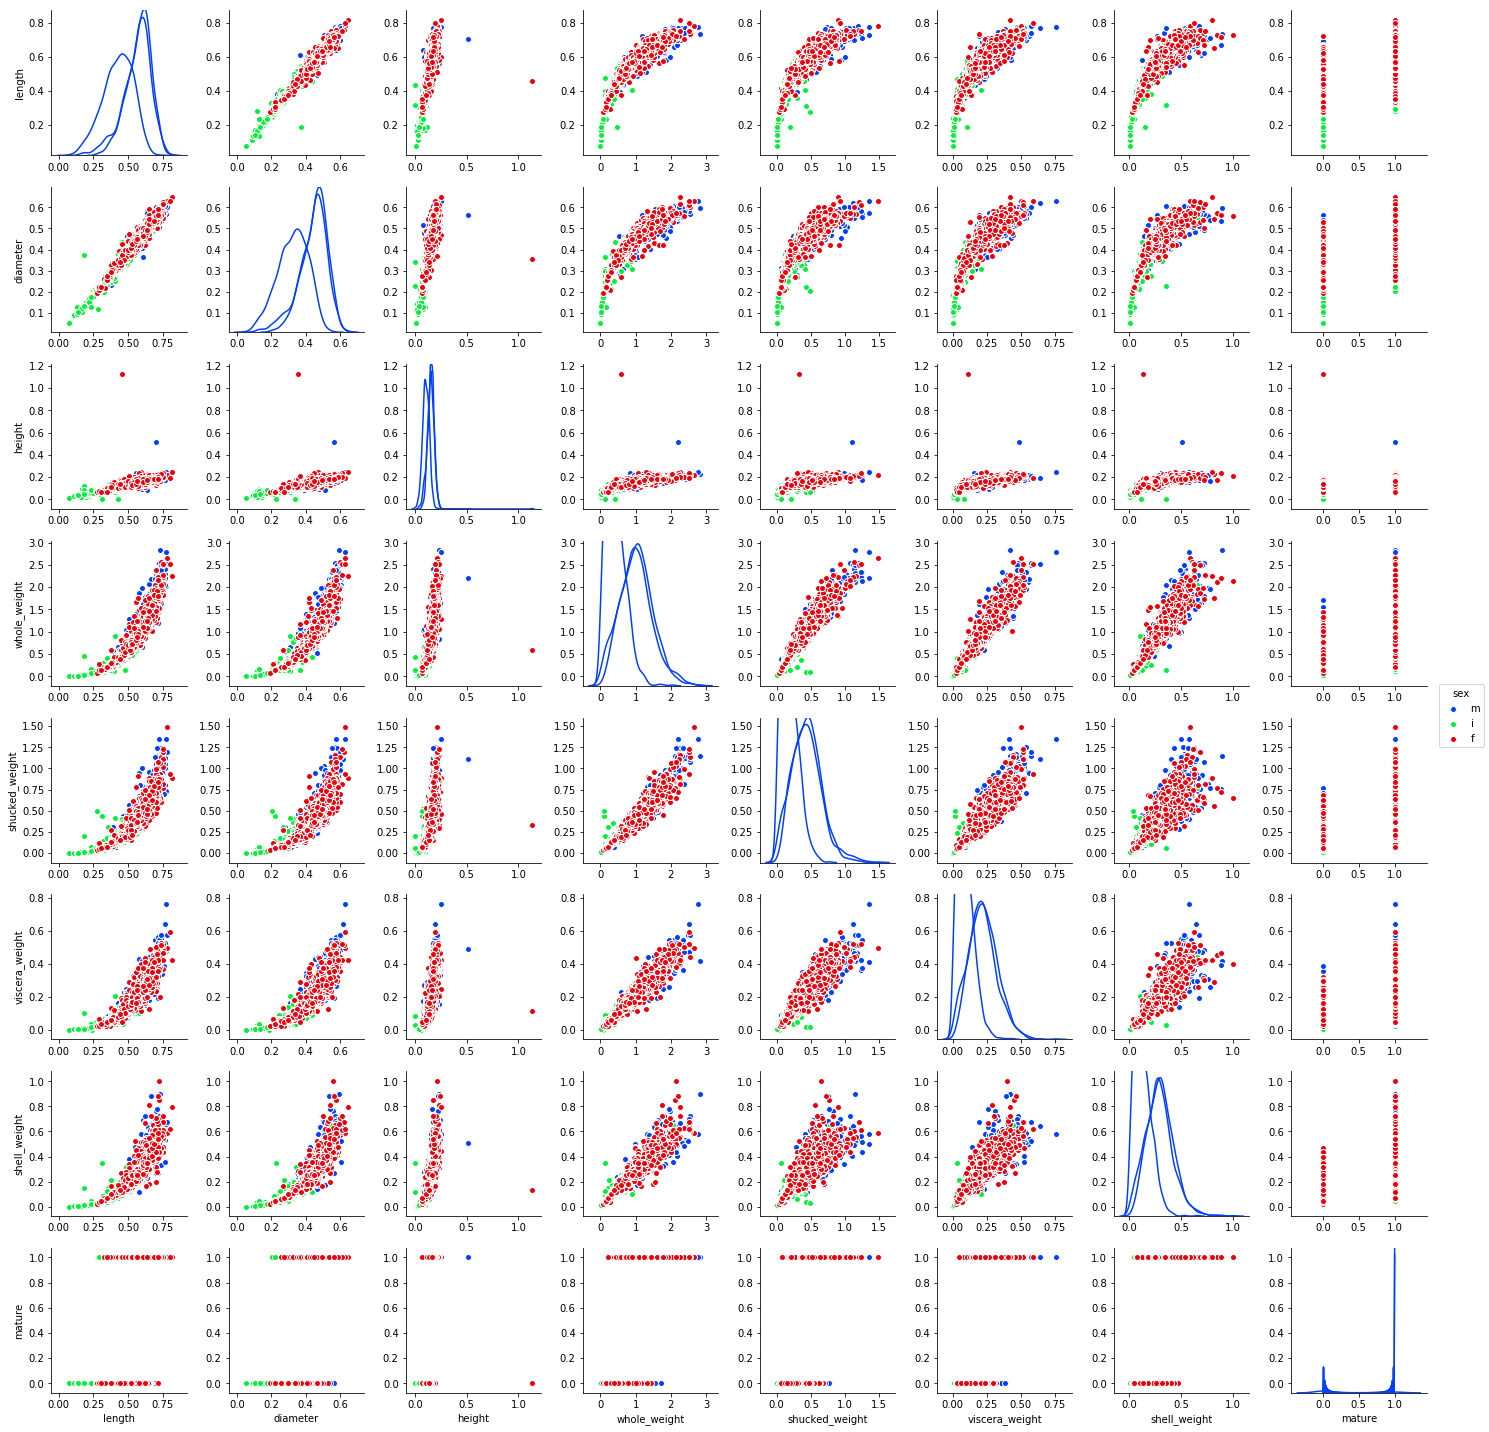

In [23]:
sns.pairplot(df_abalone_sample
            , diag_kind='kde'
            , hue='sex'
            , palette='bright')

> 성별 'I'와 'M', 'F' 간에 분포의 차이가 존재하고, 'M'과 'F' 간에는 분포 상 차이 거의 없어 보임  
  ==> **범주형 변수 one-hot encoding, 혹은 성별 모델링**  
  
> 독립변수들 간의 강한 상관관계 존재 (다중공선성 의심됨)   
  ==> **변수 제거, 혹은 차원 축소**

- 상관관계 분석 (correlation coefficients analysis)
- MADlib Correlation: http://madlib.apache.org/docs/latest/group__grp__correlation.html

In [24]:
%%read_sql -d
DROP TABLE IF EXISTS {schema}.abalone_correlation, {schema}.abalone_correlation_summary;
SELECT madlib.correlation(
    '{schema}.abalone_target'        -- source table
    , '{schema}.abalone_correlation' -- output table
    , 'length, diameter, height, whole_weight, shucked_weight, viscera_weight, shell_weight, mature' -- target columns
    , TRUE                           -- verbose
    , 'sex'                          -- grouping column
)

Query started at 10:04:22 PM KST; Query executed in 0.01 m

In [25]:
%%read_sql df_abalone_correlation
SELECT sex, variable, length, diameter, height, whole_weight, shucked_weight, viscera_weight, shell_weight, mature
FROM {schema}.abalone_correlation 
ORDER BY sex, column_position;

Query started at 10:04:23 PM KST; Query executed in 0.00 m

,sex,variable,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,mature
0,f,length,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,f,diameter,0.971081,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,f,height,0.553494,0.562149,1.000000,NaN,NaN,NaN,NaN,NaN
3,f,whole_weight,0.929116,0.925641,0.583747,1.000000,NaN,NaN,NaN,NaN
4,f,shucked_weight,0.892259,0.878953,0.531077,0.949567,1.000000,NaN,NaN,NaN
5,f,viscera_weight,0.890732,0.878164,0.550720,0.939944,0.890135,1.000000,NaN,NaN
6,f,shell_weight,0.864876,0.876235,0.580622,0.923708,0.801906,0.839690,1.000000,NaN
7,f,mature,0.325125,0.339494,0.202458,0.304832,0.237307,0.296193,0.338859,1.0
8,i,length,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,i,diameter,0.986113,1.000000,NaN,NaN,NaN,NaN,NaN,NaN


- 상관계수 Heatmap

In [26]:
df_abalone_correlation.style.background_gradient(cmap='summer')

/Users/ihongdon/anaconda3/envs/py3.5_tf1.4/lib/python3.5/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


,sex,variable,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,mature
0,f,length,1,nan,nan,nan,nan,nan,nan,nan
1,f,diameter,0.971081,1,nan,nan,nan,nan,nan,nan
2,f,height,0.553494,0.562149,1,nan,nan,nan,nan,nan
3,f,whole_weight,0.929116,0.925641,0.583747,1,nan,nan,nan,nan
4,f,shucked_weight,0.892259,0.878953,0.531077,0.949567,1,nan,nan,nan
5,f,viscera_weight,0.890732,0.878164,0.55072,0.939944,0.890135,1,nan,nan
6,f,shell_weight,0.864876,0.876235,0.580622,0.923708,0.801906,0.83969,1,nan
7,f,mature,0.325125,0.339494,0.202458,0.304832,0.237307,0.296193,0.338859,1
8,i,length,1,nan,nan,nan,nan,nan,nan,nan
9,i,diameter,0.986113,1,nan,nan,nan,nan,nan,nan


> 독립변수들 간의 강한 상관관계 존재 (다중공선성 의심됨)   
  ==> **변수 제거, 혹은 차원 축소**  
> 성별 'I'의 성숙도와 설명변수들과 강한 상관관계를 보임 (상관계수 0.5~0.6보다 큼).  
> 반면, 성별 'F', 'M'의 성숙도와 설명변수들과는 상대적으로 약한 상관관계를 보임 (상관계수 0.2~0.5 사이).  
  ==> **성(sex)별 개별 모델 개발**  

- 분산팽창지수(VIF, Variance Inflation Factor)를 통한 다중공선성(Multicollinearity) 여부 확인
- 기준: VIF가 작으면 작을 수록 좋음. VIF 지수가 10 이상이면 다중공선성이 매우 의심되므로 제거하는게 좋음

In [27]:
df_abalone_sample.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,mature
0,m,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,1
1,i,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,0
2,m,0.500,0.400,0.130,0.6645,0.2580,0.1330,0.240,1
3,m,0.355,0.280,0.095,0.2455,0.0955,0.0620,0.075,1
4,m,0.575,0.425,0.140,0.8635,0.3930,0.2270,0.200,1


In [28]:
def vif_func(df, y, X_list):
    from patsy import dmatrices
    import statsmodels.api as sm
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    
    features = "+".join(X_list)
    y, X = dmatrices('mature'+ '~' + features, df_abalone_sample, return_type='dataframe')
    
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns
    return vif

In [29]:
vif_func(df_abalone_sample, 'mature', ['length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight'])

/Users/ihongdon/anaconda3/envs/py3.5_tf1.4/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


,VIF Factor,features
0,61.096817,Intercept
1,40.370950,length
2,41.769132,diameter
3,3.458847,height
4,117.340805,whole_weight
5,29.918480,shucked_weight
6,17.622916,viscera_weight
7,22.276015,shell_weight


In [30]:
# removed 'whole_weight'
vif_func(df_abalone_sample, 'mature', ['length', 'diameter', 'height', 'shucked_weight', 'viscera_weight', 'shell_weight'])

,VIF Factor,features
0,60.958062,Intercept
1,40.351091,length
2,41.728393,diameter
3,3.457366,height
4,8.880492,shucked_weight
5,10.585213,viscera_weight
6,7.784060,shell_weight


In [31]:
# removed 'diameter'
vif_func(df_abalone_sample, 'mature', ['length', 'height', 'shucked_weight', 'viscera_weight', 'shell_weight'])

,VIF Factor,features
0,60.957968,Intercept
1,7.917729,length
2,3.408082,height
3,8.879686,shucked_weight
4,10.578081,viscera_weight
5,7.412152,shell_weight


In [32]:
# removed 'viscera_weight'
vif_func(df_abalone_sample, 'mature', ['length', 'height', 'shucked_weight', 'shell_weight'])

,VIF Factor,features
0,58.239924,Intercept
1,7.631742,length
2,3.388897,height
3,6.161330,shucked_weight
4,6.603018,shell_weight


- 다중공선성이 있는 'whole_weight', 'diameter', 'viscera_weight' 칼럼은 제거한 테이블 생성

In [33]:
%%read_sql
DROP TABLE IF EXISTS {schema}.abalone_vif_rmv CASCADE;
CREATE TABLE {schema}.abalone_vif_rmv AS
    SELECT id, sex, length, height, shucked_weight, shell_weight, rings, age, mature -- removed 'whole_weight', 'diameter', 'viscera_weight' 
    FROM {schema}.abalone_target;

Query started at 10:04:23 PM KST; Query executed in 0.00 m

## 범주형 변수 one-hot encoding
- 성별(sex) 변수를 가변수화: 'sex_f', 'sex_i', 'sex_m'
- MADlib Encoding Categorical Variables: http://madlib.apache.org/docs/latest/group__grp__encode__categorical.html
- 이번 예시에서는 'sex'의 group (F, M, I)별로 개별 모델을 만드는 방식을 취함에 따라 one-hot encoding은 적용하지 않음

%%read_sql -d
DROP TABLE IF EXISTS {schema}.abalone_encoded CASCADE;
SELECT madlib.encode_categorical_variables(
    '{schema}.abalone_vif_rmv'    -- input table
    , '{schema}.abalone_encoded' -- output table
    , 'sex'                      -- categorical column
);

%read_sql SELECT * FROM {schema}.abalone_encoded LIMIT 5;

## Training Set, Test Set 분할
- Training Set: 모델 훈련용, 80%, 반복재추출 없음
- Test Set: 모델 평가용, 20%, 반복재추출 없음
- MADlib Train-Test Split: http://madlib.apache.org/docs/latest/group__grp__train__test__split.html

In [34]:
%%read_sql -d
DROP TABLE IF EXISTS {schema}.abalone_classif CASCADE;
DROP TABLE IF EXISTS {schema}.abalone_classif_train CASCADE;
DROP TABLE IF EXISTS {schema}.abalone_classif_test CASCADE;
SELECT madlib.train_test_split(
    '{schema}.abalone_vif_rmv' -- source table
    , '{schema}.abalone_classif' -- output table
    , 0.8                      -- train_proportion
    , 0.2                      -- test_proportion
    , 'sex'                    -- strata definition
    , 'id, length, height, shucked_weight, shell_weight, mature' -- columns to output
    , FALSE                    -- sampling without replacement
    , TRUE                     -- separate output tables
);

Query started at 10:04:24 PM KST; Query executed in 0.01 m

In [35]:
%read_sql SELECT mature, count(*) FROM {schema}.abalone_classif_train GROUP BY mature;

Query started at 10:04:24 PM KST; Query executed in 0.00 m

,mature,count
0,1,2213
1,0,1127


In [36]:
%read_sql SELECT mature, count(*) FROM {schema}.abalone_classif_test GROUP BY mature;

Query started at 10:04:24 PM KST; Query executed in 0.00 m

,mature,count
0,1,557
1,0,280


In [37]:
%read_sql SELECT * FROM {schema}.abalone_classif_train LIMIT 5;

Query started at 10:04:24 PM KST; Query executed in 0.00 m

,sex,id,length,height,shucked_weight,shell_weight,mature
0,f,8,0.545,0.125,0.2940,0.260,1
1,f,23,0.565,0.155,0.4275,0.270,1
2,f,27,0.580,0.185,0.3945,0.285,1
3,f,37,0.540,0.155,0.5305,0.340,1
4,f,50,0.525,0.160,0.3545,0.245,1


In [38]:
%read_sql SELECT * FROM {schema}.abalone_classif_test LIMIT 5;

Query started at 10:04:24 PM KST; Query executed in 0.00 m

,sex,id,length,height,shucked_weight,shell_weight,mature
0,m,147,0.460,0.120,0.2240,0.1565,1
1,i,244,0.300,0.080,0.0435,0.0400,0
2,m,304,0.360,0.100,0.0885,0.0715,0
3,i,334,0.235,0.040,0.0335,0.0200,0
4,m,359,0.745,0.215,0.9265,0.7000,1


## Classification Modeling - (1) Logistic Regression
- MADlib Logistic Regression: http://madlib.apache.org/docs/latest/group__grp__logreg.html
- 'sex'를 grouping column으로 사용

In [39]:
# directory where the downloaded data and images are
import os

USER_DOCU_DIR = "/Users/ihongdon/Documents/" # change with your own directory
MADLIB_PROJECT_DIR = "1_DataScience/2_DS_TRAINING/abalone/"
MADLIB_PROJECT_PATH = os.path.join(USER_DOCU_DIR, MADLIB_PROJECT_DIR)

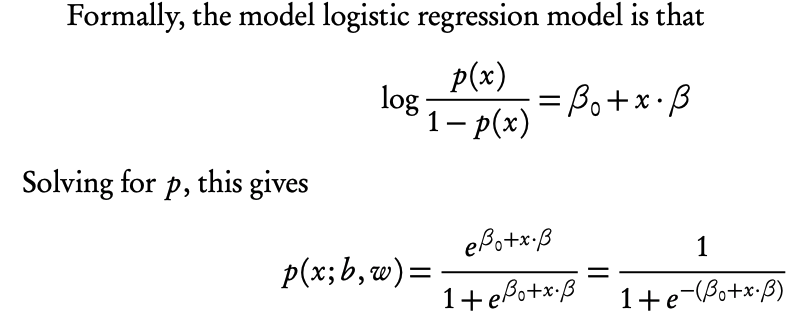

In [40]:
from IPython.display import Image

Image(filename=os.path.join(MADLIB_PROJECT_PATH, 'logistic_regression.png'))

### Logistic Regression Model Fitting using Training set

In [41]:
%%read_sql -d
DROP TABLE IF EXISTS {schema}.abalone_logregr_model, {schema}.abalone_logregr_model_summary;
SELECT madlib.logregr_train(
    '{schema}.abalone_classif_train'   -- source table
    , '{schema}.abalone_logregr_model' -- output table
    , 'mature'                         -- dependent variable
    , 'ARRAY[1, length, height, shucked_weight, shell_weight]' -- independent variables
    , 'sex'                             -- grouping column
    , 50                               -- max iterations
);

Query started at 10:04:25 PM KST; Query executed in 0.02 m

In [42]:
%%read_sql
SELECT * FROM {schema}.abalone_logregr_model_summary;

Query started at 10:04:26 PM KST; Query executed in 0.00 m

,method,source_table,out_table,dependent_varname,independent_varname,optimizer_params,num_all_groups,num_failed_groups,num_rows_processed,num_missing_rows_skipped,grouping_col
0,logregr,ds_training.abalone_classif_train,ds_training.abalone_logregr_model,mature,"ARRAY[1, length, height, shucked_weight, shell...","optimizer=irls, max_iter=50, tolerance=0.0001",3,0,3340,0,sex


In [43]:
%%read_sql
SELECT * FROM {schema}.abalone_logregr_model;

Query started at 10:04:26 PM KST; Query executed in 0.00 m

,sex,coef,log_likelihood,std_err,z_stats,p_values,odds_ratios,condition_no,num_rows_processed,num_missing_rows_skipped,num_iterations,variance_covariance
0,i,"[-6.31677740451604, 2.21594695714716, 16.67058...",-386.076119,"[1.06809053213351, 3.23409852355401, 7.3941492...","[-5.91408426015936, 0.685182266714626, 2.25456...","[3.33727022121891e-09, 0.493228912615668, 0.02...","[0.00180575335240919, 9.17008868238731, 173757...",95.749760,1073,0,7,"[[1.14081738483325, -2.85622093539317, -2.7135..."
1,m,"[-1.20057691989411, -3.11663629674988, 6.07508...",-433.472820,"[0.808587084536739, 2.41213104163857, 6.440830...","[-1.48478369597252, -1.29206757135082, 0.94321...","[0.137601132191088, 0.196333745034332, 0.34557...","[0.301020497093946, 0.0443059501190826, 434.88...",92.786316,1222,0,7,"[[0.653813073279623, -1.49634749329871, -1.916..."
2,f,"[-2.00188797265668, 2.95871991578732, -0.71754...",-327.254186,"[1.11755773323132, 3.1139851442626, 2.16157608...","[-1.79130608927772, 0.950139380477987, -0.3319...","[0.0732441895098576, 0.342041435560336, 0.7399...","[0.135080014967958, 19.2732845307562, 0.487950...",46.767594,1045,0,7,"[[1.24893528710513, -3.32286082699944, -0.3621..."


In [44]:
%%read_sql
SELECT 
    sex
    , unnest(ARRAY['intercept', 'length', 'height', 'shucked_weight', 'shell_weight']) as attribute
    , unnest(coef) as coefficient
    , unnest(std_err) as standard_error
    , unnest(z_stats) as z_stats
    , unnest(p_values) as p_values
    FROM {schema}.abalone_logregr_model;

Query started at 10:04:26 PM KST; Query executed in 0.00 m

,sex,attribute,coefficient,standard_error,z_stats,p_values
0,i,intercept,-6.316777,1.068091,-5.914084,3.337270e-09
1,i,length,2.215947,3.234099,0.685182,4.932289e-01
2,i,height,16.670586,7.394149,2.254564,2.416068e-02
3,i,shucked_weight,-9.305278,1.977526,-4.705514,2.532267e-06
4,i,shell_weight,31.858230,4.416414,7.213597,5.449302e-13
5,m,intercept,-1.200577,0.808587,-1.484784,1.376011e-01
6,m,length,-3.116636,2.412131,-1.292068,1.963337e-01
7,m,height,6.075083,6.440830,0.943214,3.455713e-01
8,m,shucked_weight,-7.163485,1.083972,-6.608552,3.880983e-11
9,m,shell_weight,26.609815,2.984896,8.914822,4.885996e-19


> 'height' 설명변수의 p-value가 유의하지 않은 것으로 나옴   
   => **'height' 설명변수 제외하고 다시 모델링**

- 'length' 설명변수를 제외하고 다시 로지스틱 회귀모형 적합

In [45]:
%%read_sql -d
DROP TABLE IF EXISTS {schema}.abalone_logregr_model2, {schema}.abalone_logregr_model2_summary;
SELECT madlib.logregr_train(
    '{schema}.abalone_classif_train'    -- source table
    , '{schema}.abalone_logregr_model2' -- output table
    , 'mature'                          -- dependent variable
    , 'ARRAY[1, length, shucked_weight, shell_weight]' -- independent variables
    , 'sex'                             -- grouping column
    , 50                                -- max iterations
);

Query started at 10:04:26 PM KST; Query executed in 0.02 m

In [46]:
%%read_sql
SELECT 
    sex
    , unnest(ARRAY['intercept', 'length', 'shucked_weight', 'shell_weight']) as attribute
    , unnest(coef) as coefficient
    , unnest(std_err) as standard_error
    , unnest(z_stats) as z_stats
    , unnest(p_values) as p_values
    FROM {schema}.abalone_logregr_model2;

Query started at 10:04:27 PM KST; Query executed in 0.00 m

,sex,attribute,coefficient,standard_error,z_stats,p_values
0,i,intercept,-5.539091,0.993478,-5.575453,2.468861e-08
1,i,length,3.642761,3.170433,1.148979,2.505647e-01
2,i,shucked_weight,-9.027012,1.973383,-4.574385,4.776216e-06
3,i,shell_weight,34.991086,4.219752,8.292215,1.111590e-16
4,m,intercept,-0.921173,0.745412,-1.235790,2.165366e-01
5,m,length,-2.523444,2.311653,-1.091619,2.750007e-01
6,m,shucked_weight,-7.139474,1.081302,-6.602661,4.038417e-11
7,m,shell_weight,27.691556,2.769964,9.997082,1.569540e-23
8,f,intercept,-2.060247,1.104654,-1.865061,6.217285e-02
9,f,length,2.929190,3.111124,0.941521,3.464377e-01


### Logistic Regression Model Evaluation using Test set
- Cross join model with table to be scored

In [47]:
%%read_sql
DROP TABLE IF EXISTS {schema}.abalone_logregr_test_proba;
CREATE TABLE {schema}.abalone_logregr_test_proba AS
    SELECT 
        test.id
        , test.sex
        , madlib.logregr_predict_prob(
            coef
            , ARRAY[1, length, shucked_weight, shell_weight]
            ) as proba
        , test.mature
    FROM {schema}.abalone_classif_test test
         , {schema}.abalone_logregr_model2 model
    WHERE test.sex = model.sex
    ORDER BY test.id
    ;

Query started at 10:04:27 PM KST; Query executed in 0.00 m

In [48]:
%%read_sql
SELECT * FROM {schema}.abalone_logregr_test_proba LIMIT 10;

Query started at 10:04:27 PM KST; Query executed in 0.00 m

,id,sex,proba,mature
0,3,f,0.879619,1
1,25,f,0.913249,1
2,29,m,0.948250,1
3,52,m,0.471403,0
4,53,m,0.606569,1
5,58,m,0.651652,0
6,92,m,0.936213,1
7,112,m,0.821047,1
8,114,m,0.838531,1
9,115,f,0.850307,1


- **AUC (Area Under the ROC Curve)**
- MADlib Prediction Metrics: http://madlib.apache.org/docs/latest/group__grp__pred.html

In [49]:
%%read_sql -d
DROP TABLE IF EXISTS {schema}.abalone_logregr_test_auc CASCADE;
SELECT madlib.area_under_roc(
    '{schema}.abalone_logregr_test_proba'  -- table_in
    , '{schema}.abalone_logregr_test_auc'  -- table_out
    , 'proba'                              -- prediction column
    , 'mature'                             -- observed column
);

Query started at 10:04:27 PM KST; Query executed in 0.00 m

In [50]:
%read_sql SELECT * FROM {schema}.abalone_logregr_test_auc;

Query started at 10:04:28 PM KST; Query executed in 0.00 m

,area_under_roc
0,0.89237


- **Confusion matrix**

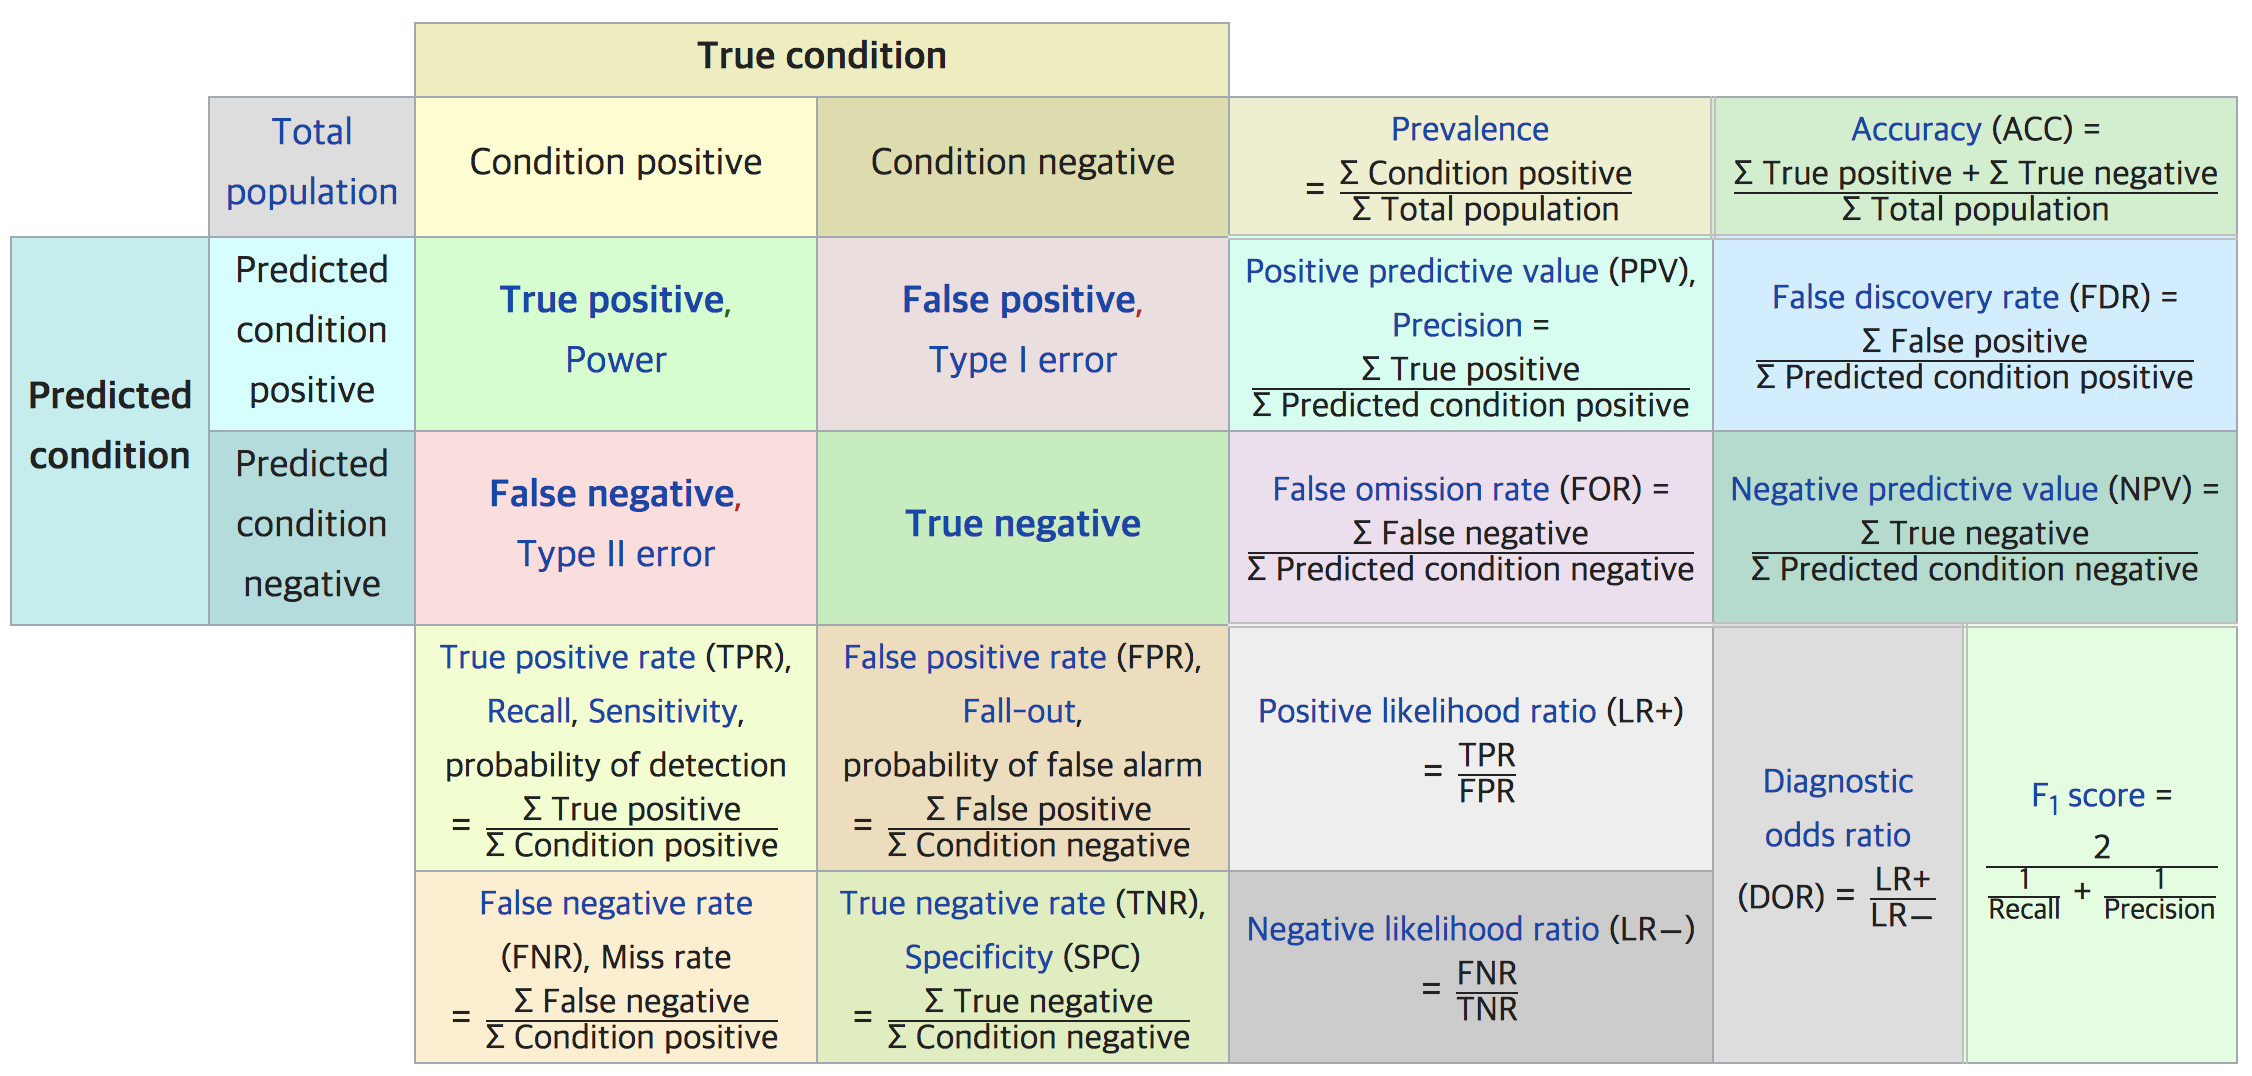

In [51]:
Image(filename=os.path.join(MADLIB_PROJECT_PATH, 'evaluation_of_binary_classifiers.png'))

In [52]:
%%read_sql
DROP TABLE IF EXISTS {schema}.abalone_logregr_test_predict;
CREATE TABLE {schema}.abalone_logregr_test_predict AS
    SELECT 
        id
        , sex
        , (proba >= 0.5)::integer AS predicted
        , mature
    FROM {schema}.abalone_logregr_test_proba;

Query started at 10:04:28 PM KST; Query executed in 0.00 m

In [53]:
%%read_sql
SELECT * FROM {schema}.abalone_logregr_test_predict LIMIT 10;

Query started at 10:04:28 PM KST; Query executed in 0.00 m

,id,sex,predicted,mature
0,18,f,1,1
1,40,m,0,1
2,41,f,1,1
3,64,m,0,0
4,68,f,1,1
5,75,f,1,1
6,91,m,1,1
7,95,m,1,1
8,117,f,1,1
9,121,f,1,1


In [54]:
%%read_sql -d
DROP TABLE IF EXISTS {schema}.abalone_logregr_test_conf_matrix;
SELECT 
    madlib.confusion_matrix(
    '{schema}.abalone_logregr_test_predict'       -- table_in
    , '{schema}.abalone_logregr_test_conf_matrix' -- table_out
    , 'predicted'                                 -- predicted value
    , 'mature'                                    -- actual value
);

Query started at 10:04:28 PM KST; Query executed in 0.00 m

In [55]:
%%read_sql
SELECT * FROM {schema}.abalone_logregr_test_conf_matrix ORDER BY row_id;

Query started at 10:04:28 PM KST; Query executed in 0.00 m

,row_id,class,confusion_arr
0,1,0,"[189, 91]"
1,2,1,"[47, 510]"


In [56]:
%%read_sql
SELEcT 
    class as actual
    , confusion_arr[1] AS predicted_0
    , confusion_arr[2] AS predicted_1
    FROM {schema}.abalone_logregr_test_conf_matrix;

Query started at 10:04:28 PM KST; Query executed in 0.00 m

,actual,predicted_0,predicted_1
0,1,47.0,510.0
1,0,189.0,91.0


- **ROC (Receiver Operating Characteristic) Curve**
- MADlib Prediction Metrics: http://madlib.apache.org/docs/latest/group__grp__pred.html

In [57]:
%%read_sql -d
DROP TABLE IF EXISTS {schema}.abalone_logregr_test_binary_metrics;
SELECT madlib.binary_classifier(
    '{schema}.abalone_logregr_test_proba'            -- table_in
    , '{schema}.abalone_logregr_test_binary_metrics' -- table_out
    , 'proba'                                        -- predicted values
    , 'mature'                                       -- observed values
);

Query started at 10:04:28 PM KST; Query executed in 0.00 m

In [58]:
%%read_sql -d logregr_metrics
SELECT * FROM {schema}.abalone_logregr_test_binary_metrics ORDER BY threshold;

Query started at 10:04:28 PM KST; Query executed in 0.00 m

In [59]:
def roc_curve_plot(fpr, tpr):
    plt.plot(fpr, tpr, marker='o', color='b')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.show()

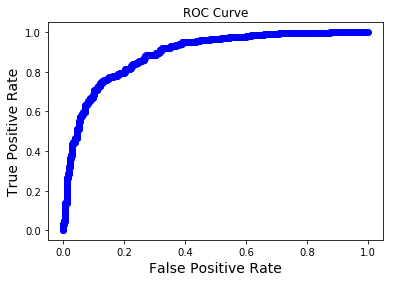

In [60]:
fpr = logregr_metrics.fpr
tpr = logregr_metrics.tpr

roc_curve_plot(fpr, tpr)

## Classification Modeling - (2) Random Forest Classifier
- MADlib Random Forest: http://madlib.apache.org/docs/latest/group__grp__random__forest.html
- Random Forest : https://en.wikipedia.org/wiki/Random_forest

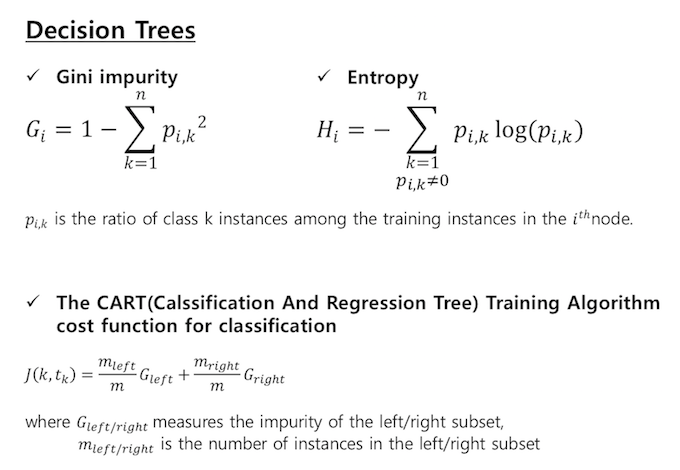

In [61]:
Image(filename=os.path.join(MADLIB_PROJECT_PATH, 'decision_trees.png'))

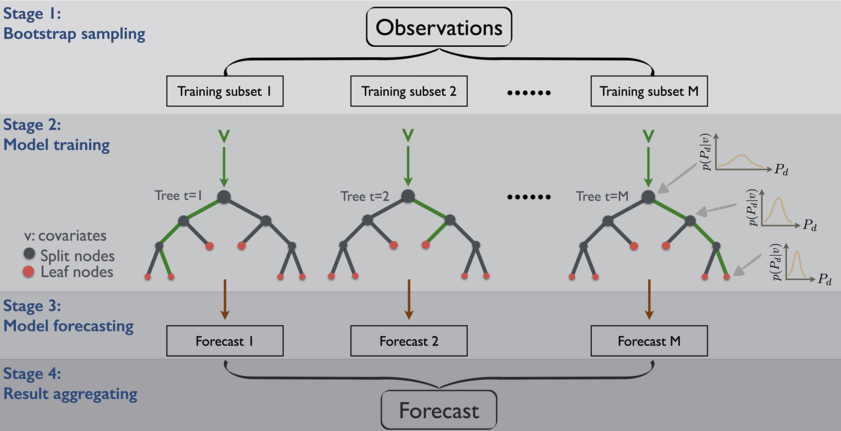

In [62]:
Image(filename=os.path.join(MADLIB_PROJECT_PATH, 'random_forest.png'))

In [63]:
%%read_sql -d
DROP TABLE IF EXISTS {schema}.abalone_rf_model, {schema}.abalone_rf_model_summary, {schema}.abalone_rf_model_group;
SELECT madlib.forest_train(
    '{schema}.abalone_classif_train' -- source table
    , '{schema}.abalone_rf_model'      -- output table
    , 'id'                           -- id column
    , 'mature'                       -- dependent variable
    , 'height, length, shucked_weight, shell_weight' -- features
    , NULL                           -- list of features to exclude
    , 'sex'                           -- grouping column
    , 100::integer                   -- number of trees
    , 2::integer                     -- number of random features
    , TRUE::boolean                  -- variable importance
    , 1::integer                     -- num_permutations
    , 6::integer                     -- max depth
    , 3::integer                     -- min split
    , 10::integer                    -- min bucket
    , 10::integer                    -- number of splits per continuous variable
);

Query started at 10:04:30 PM KST; Query executed in 0.56 m

In [64]:
%%read_sql
SELECT * FROM {schema}.abalone_rf_model_summary;

Query started at 10:05:03 PM KST; Query executed in 0.00 m

,method,is_classification,source_table,model_table,id_col_name,dependent_varname,independent_varnames,cat_features,con_features,grouping_cols,num_trees,num_random_features,max_tree_depth,min_split,min_bucket,num_splits,verbose,importance,num_permutations,num_all_groups,num_failed_groups,total_rows_processed,total_rows_skipped,dependent_var_levels,dependent_var_type,independent_var_types,null_proxy
0,forest_train,True,ds_training.abalone_classif_train,ds_training.abalone_rf_model,id,mature,"height,length,shucked_weight,shell_weight",,"height,length,shucked_weight,shell_weight",sex,100,2,6,3,10,10,False,True,1,3,0,3340,0,"0,1",integer,"double precision, double precision, double pre...",None


In [65]:
%%read_sql
SELECT * FROM {schema}.abalone_rf_model LIMIT 5;

Query started at 10:05:04 PM KST; Query executed in 0.00 m

,gid,sample_id,tree
0,2,1,\000\000\000\000\006\000\002\000\000\000\000\0...
1,1,1,\000\000\000\000\007\000\002\000\000\000\000\0...
2,2,2,\000\000\000\000\007\000\002\000\000\000\000\0...
3,3,1,\000\000\000\000\007\000\002\000\000\000\000\0...
4,2,3,\000\000\000\000\007\000\002\000\000\000\000\0...


- ** Tree Visualization **

In [66]:
%%read_sql rf_tree_1
SELECT madlib.get_tree(
    '{schema}.abalone_rf_model' -- forest_model_table
    , 1                         -- ID of the group that this tree is part of
    , 1                         -- ID of the bootstrap sample that this tree is part of
    , FALSE -- return results in dot_format
)

Query started at 10:05:04 PM KST; Query executed in 0.00 m

,get_tree
0,-------------------------------------\n - E...


In [67]:
print(rf_tree_1.iloc[0, 0])

-------------------------------------
    - Each node represented by 'id' inside ().
    - Each internal nodes has the split condition at the end, while each
        leaf node has a * at the end.
    - For each internal node (i), its child nodes are indented by 1 level
        with ids (2i+1) for True node and (2i+2) for False node.
    - Number of (weighted) rows for each response variable inside [].'
        The response label order is given as ['0', '1'].
        For each leaf, the prediction is given after the '-->'
        
-------------------------------------
(0)[152 939]  height <= 0.145
   (1)[100 245]  shell_weight <= 0.145
      (3)[43 50]  height <= 0.12
         (7)[36 39]  * --> 1
         (8)[ 7 11]  * --> 1
      (4)[ 57 195]  shell_weight <= 0.294
         (9)[ 57 173]  shucked_weight <= 0.3825
            (19)[ 32 134]  shucked_weight <= 0.262
               (39)[10 63]  height <= 0.12
                  (79)[ 6 16]  * --> 1
                  (80)[ 4 47]  * --> 1
     

In [68]:
%%read_sql rf_tree_1_dot
SELECT madlib.get_tree(
    '{schema}.abalone_rf_model'
    , 1
    , 1
    , TRUE -- return results in dot_format
)

Query started at 10:05:04 PM KST; Query executed in 0.00 m

,get_tree
0,"digraph ""Classification tree for ds_training.a..."


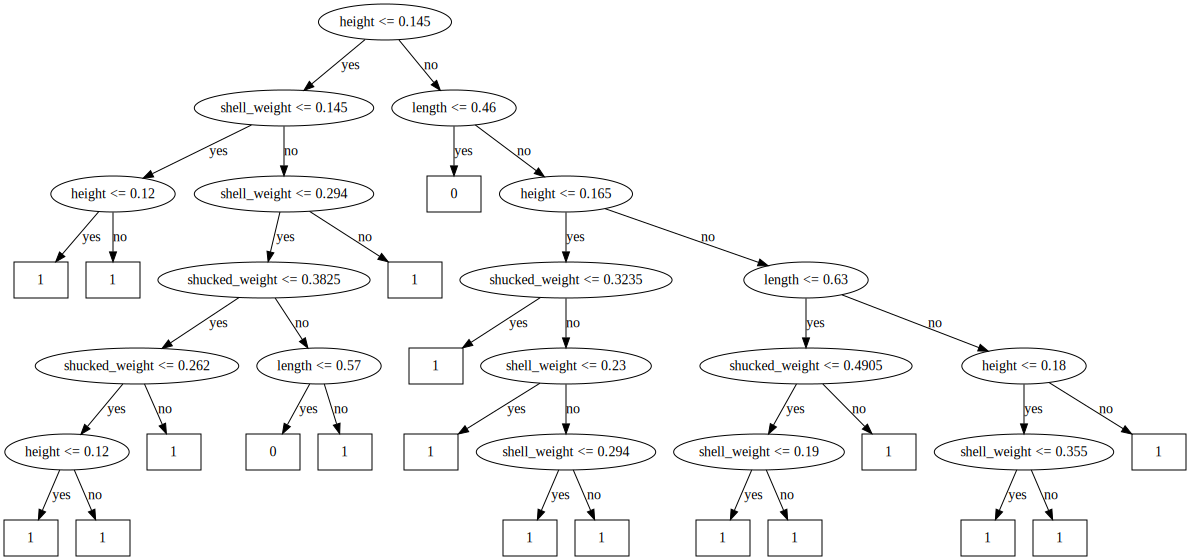

In [69]:
rf_dot_source = graphviz.Source(rf_tree_1_dot.iloc[0,0])
display(rf_dot_source)

- **Variabl Importance**  
   : out of bag variable importance, impurity variable importance   
   : 총합이 100이 되도록 scale 조정

In [70]:
%%read_sql -d
DROP TABLE IF EXISTS {schema}.abalone_rf_importance;
SELECT madlib.get_var_importance(
    '{schema}.abalone_rf_model'        -- model table
    , '{schema}.abalone_rf_importance' -- output table
);

Query started at 10:05:04 PM KST; Query executed in 0.00 m

In [71]:
%%read_sql
SELECT * 
    FROM {schema}.abalone_rf_importance 
    ORDER BY sex, impurity_var_importance DESC;

Query started at 10:05:04 PM KST; Query executed in 0.00 m

,sex,feature,oob_var_importance,impurity_var_importance
0,f,shell_weight,29.728390,29.575397
1,f,shucked_weight,48.121654,28.482167
2,f,height,0.000000,21.373525
3,f,length,22.149956,20.568911
4,i,shell_weight,45.735020,39.287519
5,i,length,25.944410,23.505280
6,i,height,28.320570,21.582487
7,i,shucked_weight,0.000000,15.624714
8,m,shell_weight,46.803929,34.627685
9,m,shucked_weight,34.325606,32.920740


- **분류 모형 적용 (predict)**

In [72]:
%%read_sql -d
DROP TABLE IF EXISTS {schema}.abalone_rf_test_proba;
SELECT madlib.forest_predict(
    '{schema}.abalone_rf_model'        -- random forest model
    , '{schema}.abalone_classif_test'  -- test table
    , '{schema}.abalone_rf_test_proba' -- output table
    , 'prob'                           -- type
);

Query started at 10:05:04 PM KST; Query executed in 0.01 m

In [73]:
%%read_sql
SELECT * FROM {schema}.abalone_rf_test_proba LIMIT 10;

Query started at 10:05:05 PM KST; Query executed in 0.00 m

,id,estimated_prob_0,estimated_prob_1
0,150,1.00,0.00
1,208,0.99,0.01
2,234,1.00,0.00
3,244,1.00,0.00
4,297,1.00,0.00
5,395,1.00,0.00
6,511,0.00,1.00
7,584,0.93,0.07
8,604,0.74,0.26
9,606,0.61,0.39


In [74]:
%%read_sql
DROP TABLE IF EXISTS {schema}.abalone_rf_test_predict;
CREATE TABLE {schema}.abalone_rf_test_predict AS 
    SELECT 
        test.id
        , test.sex
        , prob.estimated_prob_1
        , (prob.estimated_prob_1 >= 0.5)::integer AS predicted_class
        , test.mature AS actual_class
    FROM {schema}.abalone_rf_test_proba prob
    INNER JOIN {schema}.abalone_classif_test test 
    ON prob.id = test.id;

Query started at 10:05:05 PM KST; Query executed in 0.00 m

In [75]:
%%read_sql
SELECT * FROM {schema}.abalone_rf_test_predict LIMIT 10;

Query started at 10:05:05 PM KST; Query executed in 0.00 m

,id,sex,estimated_prob_1,predicted_class,actual_class
0,147,m,0.82,1,1
1,334,i,0.00,0,0
2,143,m,1.00,1,1
3,282,i,0.03,0,0
4,95,m,1.00,1,1
5,243,i,0.00,0,0
6,398,m,1.00,1,0
7,589,m,0.86,1,1
8,571,i,0.07,0,1
9,689,m,0.98,1,1


- **Confusion Matrix**

In [76]:
%%read_sql -d
DROP TABLE IF EXISTS {schema}.abalone_rf_test_conf_matrix CASCADE;
SELECT madlib.confusion_matrix(
    '{schema}.abalone_rf_test_predict'       -- source table
    , '{schema}.abalone_rf_test_conf_matrix' -- output table
    , 'predicted_class'                      -- predicted column
    , 'actual_class'                         -- observed column
);

Query started at 10:05:05 PM KST; Query executed in 0.00 m

In [77]:
%%read_sql
SELECT * FROM {schema}.abalone_rf_test_conf_matrix;

Query started at 10:05:05 PM KST; Query executed in 0.00 m

,row_id,class,confusion_arr
0,1,0,"[189, 91]"
1,2,1,"[45, 512]"


In [78]:
%%read_sql
SELECT class
    , confusion_arr[1] AS predicted_0
    , confusion_arr[2] AS predicted_1
    FROM {schema}.abalone_rf_test_conf_matrix
    ORDER BY class;

Query started at 10:05:06 PM KST; Query executed in 0.00 m

,class,predicted_0,predicted_1
0,0,189.0,91.0
1,1,45.0,512.0


- **ROC Curve**

In [79]:
%%read_sql -d
DROP TABLE IF EXISTS {schema}.abalone_rf_test_binary_metrics;
SELECT madlib.binary_classifier(
    '{schema}.abalone_rf_test_predict'          -- source table
    , '{schema}.abalone_rf_test_binary_metrics' -- output table
    , 'estimated_prob_1'                        -- predicted_class
    , 'actual_class'                            -- actual_class
);

Query started at 10:05:06 PM KST; Query executed in 0.00 m

In [80]:
%%read_sql
SELECT * FROM {schema}.abalone_rf_test_binary_metrics ORDER BY threshold LIMIT 5;

Query started at 10:05:06 PM KST; Query executed in 0.00 m

,threshold,tp,fp,fn,tn,tpr,tnr,ppv,npv,fpr,fdr,fnr,acc,f1
0,0.00,557.0,280.0,0.0,0.0,1.000000,0.000000,0.665472,NaN,1.000000,0.334528,0.000000,0.665472,0.799139
1,0.01,549.0,165.0,8.0,115.0,0.985637,0.410714,0.768908,0.934959,0.589286,0.231092,0.014363,0.793309,0.863887
2,0.02,546.0,160.0,11.0,120.0,0.980251,0.428571,0.773371,0.916031,0.571429,0.226629,0.019749,0.795699,0.864608
3,0.03,543.0,154.0,14.0,126.0,0.974865,0.450000,0.779053,0.900000,0.550000,0.220947,0.025135,0.799283,0.866029
4,0.04,541.0,151.0,16.0,129.0,0.971275,0.460714,0.781792,0.889655,0.539286,0.218208,0.028725,0.800478,0.866293


In [81]:
%%read_sql -d df_rf_metrics
SELECT fpr, tpr FROM {schema}.abalone_rf_test_binary_metrics ORDER BY threshold;

Query started at 10:05:06 PM KST; Query executed in 0.00 m

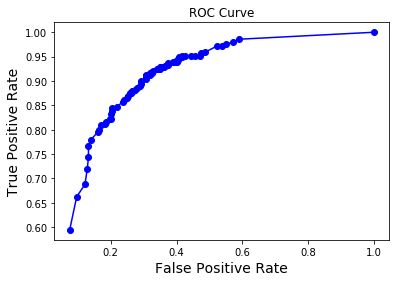

In [82]:
fpr_rf = df_rf_metrics.fpr
tpr_rf = df_rf_metrics.tpr

roc_curve_plot(fpr_rf, tpr_rf)

- ** AUC (Area Under the Curve) **

In [83]:
%%read_sql -d
DROP TABLE IF EXISTS {schema}.abalone_rf_test_auc CASCADE;
SELECT madlib.area_under_roc(
    '{schema}.abalone_rf_test_predict' -- source table
    , '{schema}.abalone_rf_test_auc'   -- output table
    , 'estimated_prob_1'               -- predicted col
    , 'actual_class'                   -- observed col
);

Query started at 10:05:06 PM KST; Query executed in 0.00 m

In [84]:
%%read_sql
SELECT * FROM {schema}.abalone_rf_test_auc;

Query started at 10:05:06 PM KST; Query executed in 0.00 m

,area_under_roc
0,0.883925


 -- THE END --